In [1]:
import os
from copy import copy
from fractions import Fraction

import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import bootstrap

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from datasets import get_mpg
from mapie.conformity_scores.residual_conformity_scores import (
    GPConformityScore
)
from mapie.metrics import (
    regression_coverage_score_v2,
    regression_mean_width_score
)
from mapie.regression import MapieRegressor
from mapie.metrics import spearman_correlation, q2
from plot_functions import plot_width_error
from wrappers import GpOTtoSklearnStd

%load_ext autoreload
%autoreload 2

In [2]:
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
BLUE_1 = np.array([[26, 54, 105]]) / 255
BLUE_2 = np.array([[48, 112, 170]]) / 255
VIOLET = np.array([[84, 13, 46]]) / 255
ORANGE = np.array([[223, 84, 49]]) / 255
YELLOW = np.array([[242, 188, 64]]) / 255

COLORS = {
    "GP": BLUE_1,
    "J+": BLUE_2,
    "J-minmax": VIOLET,
    "J+GP": ORANGE,
    "J-minmax-GP": YELLOW
}

# Change working dir to be able to load the dataset

In [4]:
os.chdir("../../")  # necessary since notebook is in subfolder, to run only once

# Load and split dataset

In [5]:
X, y = get_mpg()

# Split into train test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)


print(
    f"  N training points = {len(X_train_scale)}\n",
    f" N testing points = {len(X_test_scale)}"
)


  N training points = 313
  N testing points = 79


# Define the different tested models

### Model hyper-parameters

In [6]:
noise = .1  # Noise level for the nugget effect


In [7]:
nus = [3/2]  # add other values if you want to test more kernels
betas = [.5]  # add other values if you want to test more betas

models_hp = {
    "GP": {
        "nu": {nu: [None] for nu in nus}
    },
    "J+": {
        "nu": {nu: [None] for nu in nus}
    },
    "J-minmax": {
        "nu": {nu: [None] for nu in nus}
    },
    "J+GP": {
        "nu": {nu: betas for nu in nus}
    },
    "J-minmax-GP": {
        "nu": {nu: betas for nu in nus}
    }
}

### Define models according to hyper-parameters 

In [8]:
models = {}

for method in models_hp.keys():
    for nu in models_hp[method]["nu"].keys():
        for power_std in models_hp[method]["nu"][nu]:
            models[(method, nu, power_std)] = {
                "estimator": GpOTtoSklearnStd(
                    scale=1, amplitude=1.0, nu=nu, noise=noise
                ),
                "color": COLORS[method]
            }

### Define global models to train be trained in LOO (so that we don't have to train one model for each value of Beta)

In [9]:
global_models = {}
for nu in nus:
    global_models[nu] = {
        "estimator": GpOTtoSklearnStd(
            scale=1, amplitude=1.0, nu=nu, noise=noise
        )
    }

# Fit the GPs

In [10]:
for model_name, model in models.items():
    if model_name[0] == "GP":
        print("Fitting ", model_name)
        model["estimator"].fit(X_train_scale, y_train)

Fitting  ('GP', 1.5, None)


WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]


In [11]:
for model_name, model in models.items():
    if model_name[0] == "GP":
        print(
            model_name,
            "MSE:",
            mean_squared_error(
                y_test, model["estimator"].predict(X_test_scale)
            )
        )


for model_name, model in models.items():
    if model_name[0] == "GP":
        print(
            model_name,
            "Q2:",
            q2(
                y_test, model["estimator"].predict(X_test_scale)
            )
        )

('GP', 1.5, None) MSE: 5.491269269868525
('GP', 1.5, None) Q2: 0.892413665336419


# Fit MAPIE

### Fit the global MAPIE estimators

In [12]:
for model_name, model in global_models.items():
    global_models[model_name]["mapie_estimator_std"] = MapieRegressor(
        estimator=model["estimator"],
        conformity_score=GPConformityScore(sym=True),
        cv=-1,
        method="plus",
        model_has_std=True,
        random_state=42
    )
    global_models[model_name]["mapie_estimator_no_std"] = MapieRegressor(
        estimator=model["estimator"],
        conformity_score=None,
        cv=-1,
        method="plus",
        model_has_std=False,
        random_state=42
    )

for model_name, model in global_models.items():
    print("Fitting Global model std", model_name)
    model["mapie_estimator_std"].fit(X_train_scale, y_train)
    print("Fitting Global model no std", model_name)
    model["mapie_estimator_no_std"].fit(X_train_scale, y_train)

Fitting Global model std 1.5


WRN - (previous message repeated 25 times)
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.5232,8.39973,11.943,6.62191,4.96357]
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]
WRN - (previous message repeated 24 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]
WRN - (previous message repeated 39 times)
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.161,6.62191,4.96357]
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]
WRN - (previous message repeated 29 times)
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.5876,6.62191,4.96357]
WRN - Warning! For coherency we set scale upper bounds = [5.89023

Fitting Global model no std 1.5


WRN - (previous message repeated 49 times)
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.5232,8.39973,11.943,6.62191,4.96357]
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]
WRN - (previous message repeated 24 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]
WRN - (previous message repeated 39 times)
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.161,6.62191,4.96357]
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.943,6.62191,4.96357]
WRN - (previous message repeated 29 times)
WRN - Warning! For coherency we set scale upper bounds = [5.89023,7.43238,9.62785,8.39973,11.5876,6.62191,4.96357]
WRN - Warning! For coherency we set scale upper bounds = [5.89023

### Fit all MAPIE estimators with the previously trained LOO models

In [ ]:
for model_name, model in models.items():
    if model_name[0] != "GP":
        nu = model_name[1]
        method = "plus" if "+" in model_name[0] else "minmax"
        if "GP" in model_name[0]:
            cs = GPConformityScore(sym=True, power=model_name[2])
            estimator_ = copy(
                global_models[nu]["mapie_estimator_std"].estimator_
            )
            estimator_.method = method
        else:
            cs = None
            estimator_ = copy(
                global_models[nu]["mapie_estimator_no_std"].estimator_
            )
            estimator_.method = method

        models[model_name]["mapie_estimator"] = MapieRegressor(
            estimator=estimator_,
            conformity_score=cs,
            cv=-1,
            method=method,
            model_has_std=True if "GP" in model_name[0] else False,
            random_state=42
        )

In [ ]:
for model_name, model in models.items():
    if model_name[0] != "GP":
        print("Fitting MAPIE", model_name)
        model["mapie_estimator"].fit(X_train_scale, y_train)

Fitting MAPIE ('J+', 1.5, None)
Fitting MAPIE ('J-minmnax', 1.5, None)
Fitting MAPIE ('J+GP', 1.5, 0.5)
Fitting MAPIE ('J-minmax-GP', 1.5, 0.5)


# Coverage and correlation plots

In [ ]:
def get_model_name(model_name):
    if model_name[0] == "GP":
        return "GP Credibility Interval"
    else:
        return model_name[0]

### Get prediction sets for each method

In [ ]:
ALPHA = np.arange(0.01, 1, 0.01)
q_alpha_min = scipy.stats.norm.ppf(ALPHA / 2)
q_alpha_max = scipy.stats.norm.ppf(1 - ALPHA / 2)
for model_name, model in models.items():
    if model_name[0] == "GP":
        y_mean, y_std = model["estimator"].predict(
            X_test_scale, return_std=True
        )
        y_pss_gp = np.concatenate(
            [
                (
                    y_mean.reshape(-1, 1) +
                    y_std.reshape(-1, 1) * q_alpha_min.reshape(1, -1)
                )[:, np.newaxis, :],
                (
                    y_mean.reshape(-1, 1) +
                    y_std.reshape(-1, 1) * q_alpha_max.reshape(1, -1)
                )[:, np.newaxis, :]
            ],
            axis=1
        )
        model["y_pss"] = y_pss_gp
    else:
        _, y_pss = model["mapie_estimator"].predict(X_test_scale, alpha=ALPHA)
        model["y_pss"] = y_pss

### Get coverage and average width for each method

In [ ]:
for model_name, model in models.items():
    model["coverage"] = [
        regression_coverage_score_v2(y_test, model["y_pss"][:, :, i])
        for i, _ in enumerate(ALPHA)
    ]
    model["average_width"] = [
        regression_mean_width_score(
            model["y_pss"][:, 1, i], model["y_pss"][:, 0, i]
        )
        for i, _ in enumerate(ALPHA)
    ]

### Get correlation between width of the PI and the error of the model

In [ ]:
for model_name, model in models.items():
    if model_name[0] != "GP":
        model["errors"] = np.abs(
            model["mapie_estimator"].predict(X_test_scale, alpha=None) - y_test
        )
        model["width"] = np.abs(
            model["y_pss"][:, 0, :] - model["y_pss"][:, 1, :]
        )
    else:
        model["errors"] = np.abs(
            model["estimator"].predict(X_test_scale) - y_test
        )
        model["width"] = np.abs(
            model["y_pss"][:, 0, :] - model["y_pss"][:, 1, :]
        )

for model_name, model in models.items():
    model["spearman_correlation_to_error"] = []
    for index_confidence in range(len(ALPHA)):
        str_vect = [
            e + '--' + w for e, w in zip(
                model["errors"].astype("str").tolist(),
                model["width"][:, index_confidence].astype("str").tolist()
            )
        ]
        model["spearman_correlation_to_error"].append(bootstrap(
            (np.array(str_vect), ),
            spearman_correlation,
            axis=0,
            n_resamples=999,
            random_state=42
        ))

### Plot for coverage and interval width

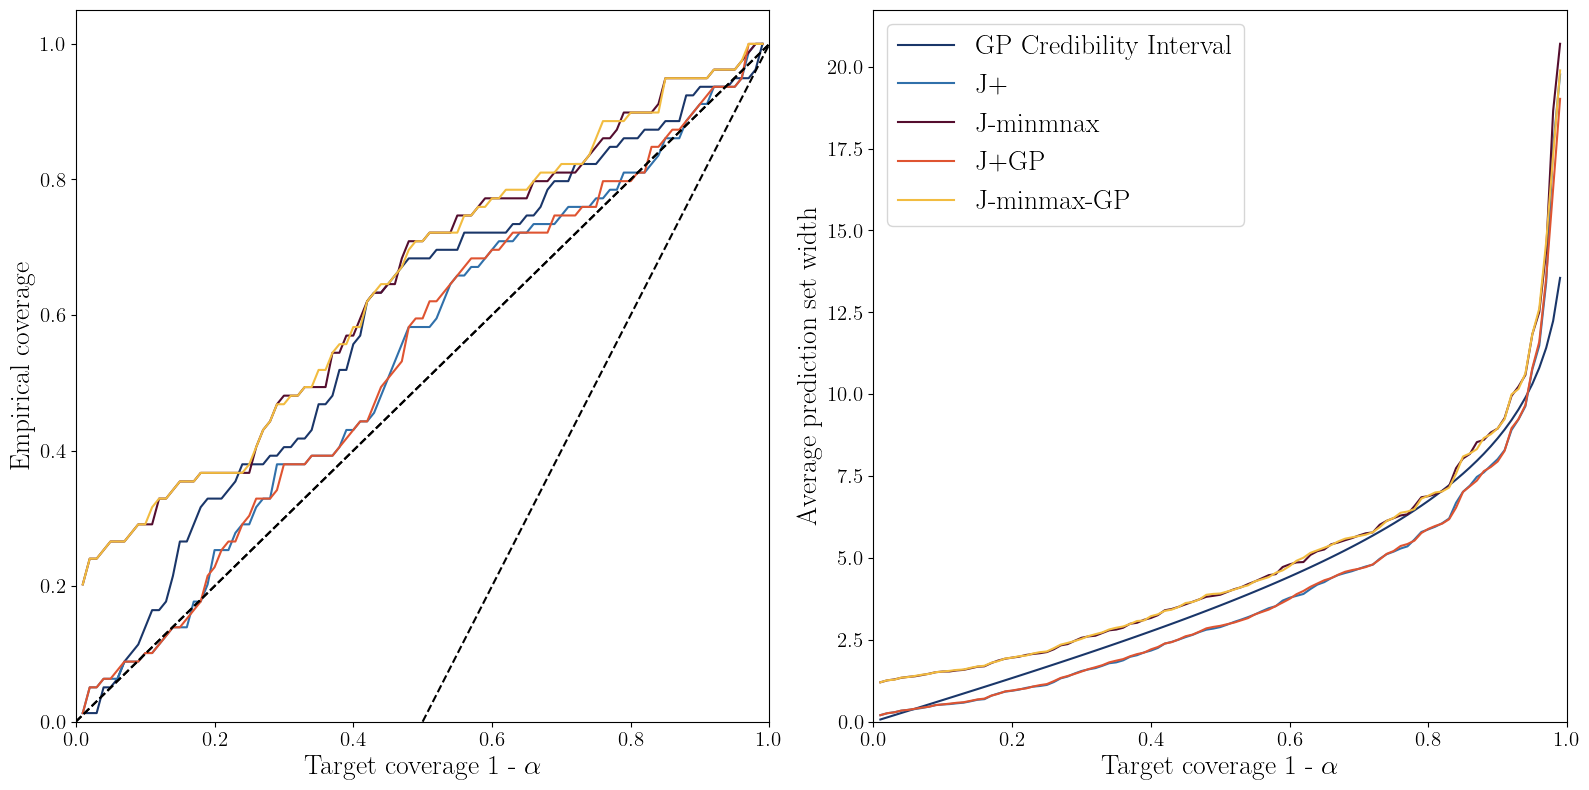

In [ ]:
fs = 20
ncols = 2
nrows = 1
s = 8
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for model_name, model in models.items():
    cov = model["coverage"]
    ax[0, 0].plot(
         1 - ALPHA, cov,
         label=get_model_name(model_name),
         color=model["color"]
    )
ax[0, 0].plot([[0, 0], [1, 1]], linestyle='dashed', c='black')
ax[0, 0].plot([0.5, 1], [0, 1], linestyle='dashed', c='black')
ax[0, 0].set_ylabel("Empirical coverage", fontsize=fs)


for model_name, model in models.items():
    width = model["average_width"]
    ax[0, 1].plot(
         1 - ALPHA, width,
         label=get_model_name(model_name),
         color=model["color"]
    )
ax[0, 1].set_ylabel("Average prediction set width", fontsize=fs)

for i in (0, 1):
        ax[0, i].set_xlabel(r"Target coverage 1 - $\alpha$", fontsize=fs)
        ax[0, i].set_xlim(0, 1)
        ax[0, i].set_ylim(0)
        ax[0, i].tick_params(axis="x", labelsize=15)
        ax[0, i].tick_params(axis="y", labelsize=15)

ax[0, 1].legend(fontsize=20, loc="upper left")
plt.tight_layout()
plt.savefig("paper_results/plots/mpg_cov.pdf")
plt.show()

### Plot of the correlation for a confidence level of 90%

In [ ]:
CONFIDENCE = .90
index_confidence = np.argmax(np.isclose(ALPHA, 1 - CONFIDENCE))

In [ ]:
index_confidence

9

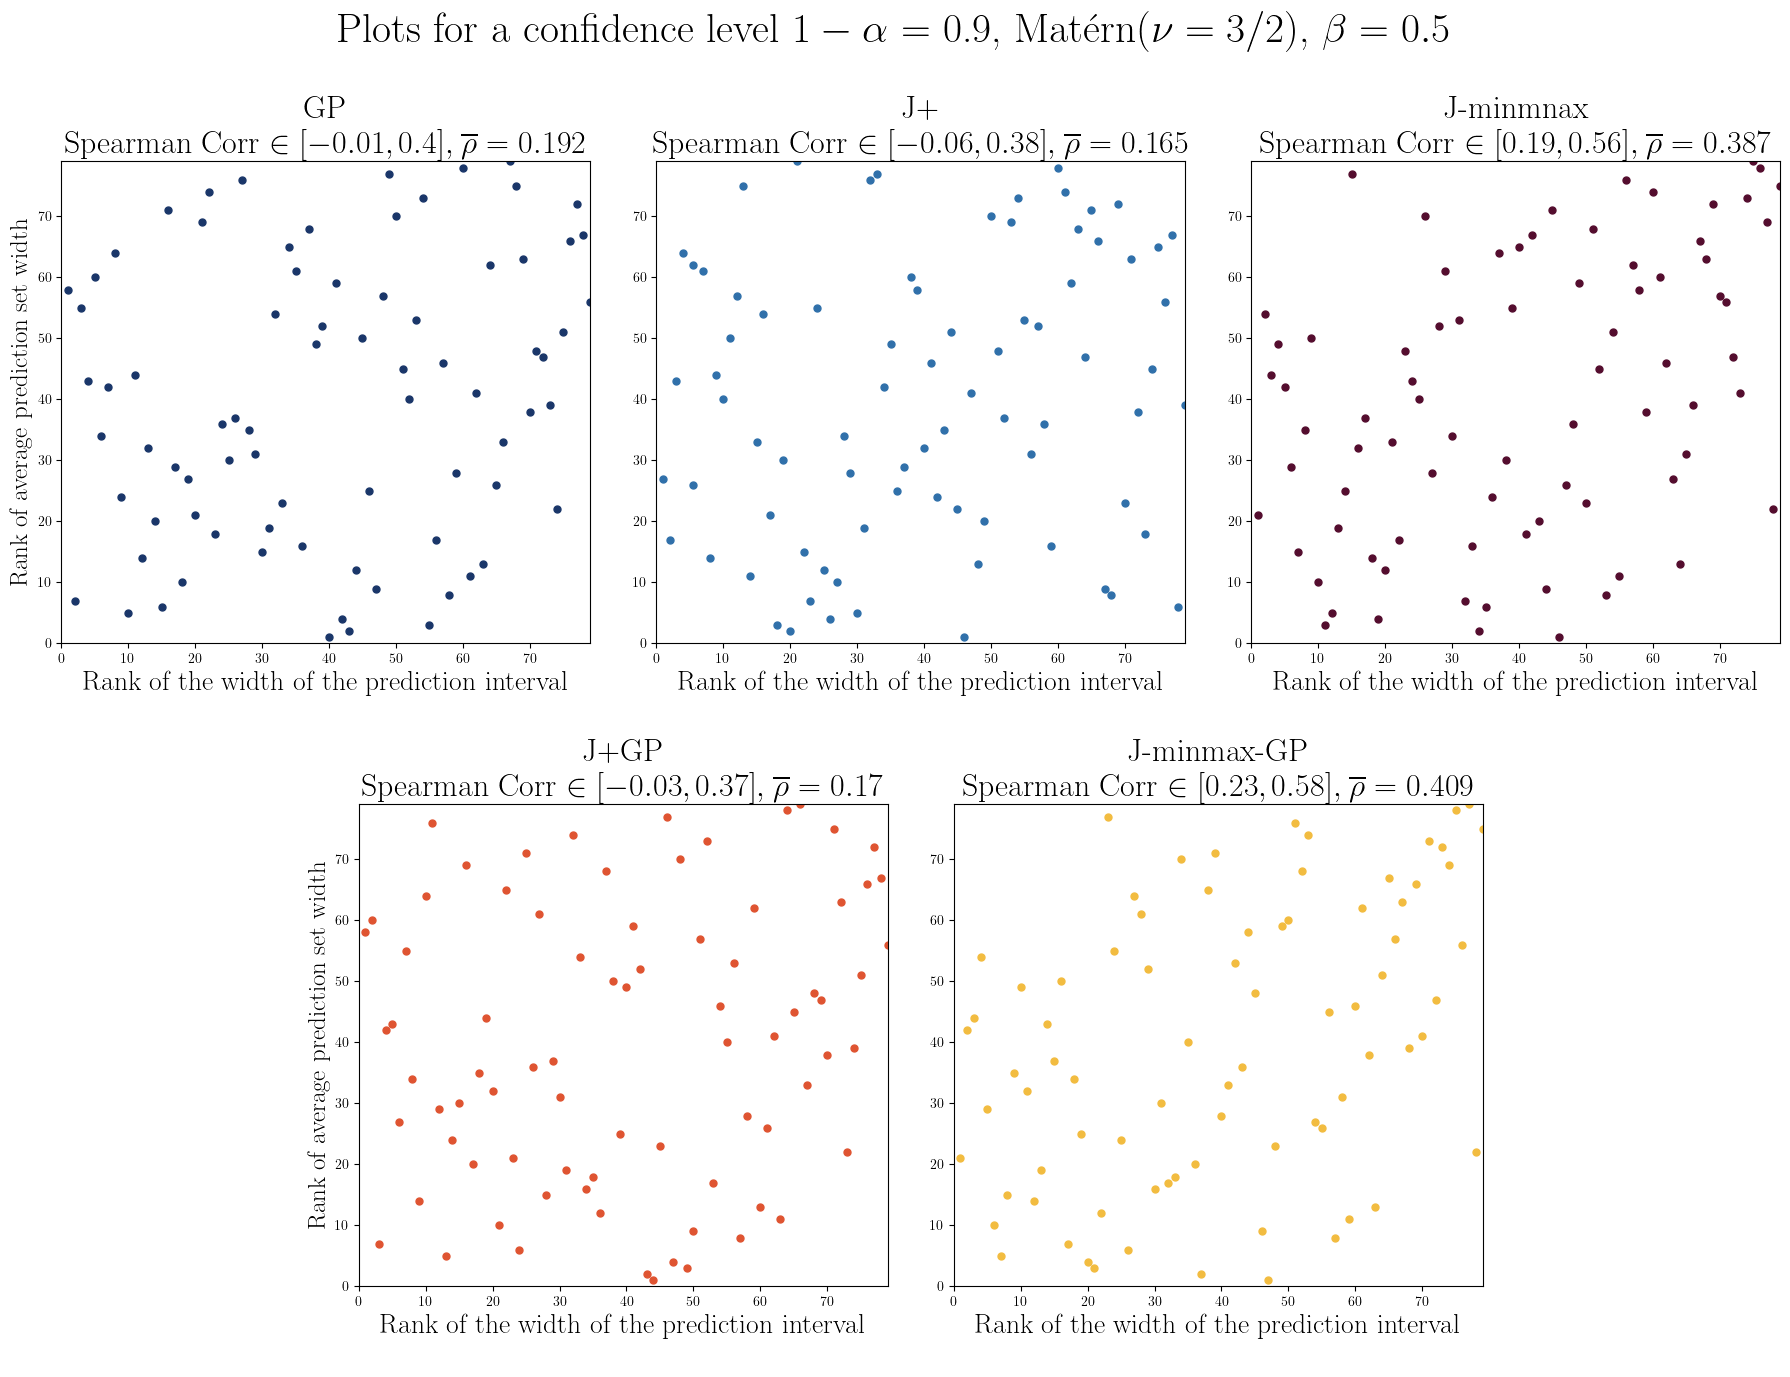

In [ ]:
import matplotlib as mpl
fig = plt.figure(figsize=(18, 14))  
spec = mpl.gridspec.GridSpec(ncols=6, nrows=2) # 6 columns evenly divides both 2 & 3

ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[0,4:])
ax4 = fig.add_subplot(spec[1,1:3]) # row 0 with axes spanning 2 cols on odds
ax5 = fig.add_subplot(spec[1,3:5])

axes = [ax1, ax2, ax3, ax4, ax5]
axes[0].set_ylabel("Rank of average prediction set width", fontsize=18)
axes[3].set_ylabel("Rank of average prediction set width", fontsize=18)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    ci = model["spearman_correlation_to_error"][index_confidence].confidence_interval
    mean_correlation = np.mean(model["spearman_correlation_to_error"][index_confidence].bootstrap_distribution)
    plot_width_error(model, model_name, axes[i], index_confidence)
fig.suptitle(
    r"Plots for a confidence level $1 - \alpha$ = " + str(round(CONFIDENCE, 2)) +
    r", Matérn($\nu=" + str(Fraction(nus[0])) + r"$), $\beta=" + str(betas[0]) +r"$" "\n",
    fontsize=30
)

plt.subplots_adjust(hspace=.35)
plt.tight_layout()
plt.savefig("paper_results/plots/mpg_corr.pdf")

In [ ]:
nu

1.5